In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
## Now import all the model libraries
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [2]:
data=pd.read_csv("data/StudentsPerformance.csv")

In [3]:
data.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

In [4]:
data["avg_score"]=round((data["math score"]+data["reading score"]+data["writing score"])/3,0)

In [5]:
data.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  avg_score  
0                    none          72             72             74       73.0  
1               completed          69             90             88       82.0  
2                    none          90             95             93       93.0  
3                    none          47             57             44       49.0  
4                    none          76             78             75       76.0

#### Devide data x and y(target and featues)

In [6]:
y=data["avg_score"]
y

0      73.0
1      82.0
2      93.0
3      49.0
4      76.0
       ... 
995    94.0
996    57.0
997    65.0
998    74.0
999    83.0
Name: avg_score, Length: 1000, dtype: float64

In [7]:
x=data.drop(["avg_score",'math score', 'reading score', 'writing score'],axis=1)

In [8]:
cat_features=x.select_dtypes("object").columns
numeric_features=x.select_dtypes(["int","float"]).columns

In [9]:
numeric_features

Index([], dtype='object')

In [10]:
cat_features

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')

In [11]:
num_scaler=StandardScaler()
cat_encoder=OneHotEncoder()

### Use of ColumnTrasnformer
1. apply the onehot encoding on all the categorical featues.
2. apply the standard scaler on the all numeric features

In [12]:
transformer=ColumnTransformer([("cat",cat_encoder,cat_features)])

In [13]:
x=transformer.fit_transform(x)

In [14]:
x.shape

(1000, 17)

In [15]:
x

<1000x17 sparse matrix of type '<class 'numpy.float64'>'
	with 5000 stored elements in Compressed Sparse Row format>

In [16]:
x=pd.DataFrame(x.toarray())

In [17]:
x

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2    1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
3    0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   
4    0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
996  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
997  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
998  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
999  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   

      14   15   16  
0    1.0  0.0  1.0  
1    1.0  1.0  0.0  
2    1.0  0.0  1.0  
3    0.0  0.0  1.0  
4    1.0  0.0  1.0  
..   ...  ...  ...  
995  1.0  1.0  0.0  
996  0.0  0.0  1.0  
997  0.0  1.0  0.0  
998  1.0  1.0  0.0  
999  0.0  0.0  1.0  

[1000 rows x 17 columns]

#### now split the data into train_test_split

In [18]:
from sklearn.model_selection import train_test_split


In [19]:
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [20]:
print(x_train.shape)
x_test.shape

(670, 17)


(330, 17)

In [21]:
print(y_train.shape)
y_test.shape

(670,)


(330,)

### Create a Function for the evaluate the model

In [22]:
##for check all the results
def evaluate(true,predicted):
    r2_square=r2_score(true,predicted)
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    return r2_square,mae,mse,rmse
    

In [23]:
models={
    "Linear Regression":LinearRegression(),
    "Lasso":Lasso(),
    "Ridge":Ridge(),
    "K Neighbour":KNeighborsRegressor(),
    "Decision Tree":DecisionTreeRegressor(),
    "Random Forest":RandomForestRegressor(),
    "XgBoost":XGBRegressor(),
    "CatBoost":CatBoostRegressor()
}

In [24]:
list(models.values())[0]

LinearRegression()

In [25]:
model_list=[]
r2_score_list=[]
for i in range(len(list(models))):
    model=list(models.values())[i]
    #train the model
    model.fit(x_train,y_train)
    
    #now make the prediction using the models
    y_train_pred=model.predict(x_train)
    y_test_pred=model.predict(x_test)
    
    #now evalutate all the score using our predefined function
    train_r2_square,train_mae,train_mse,train_rmse=evaluate(y_train,y_train_pred)
    test_r2_square,test_mae,test_mse,test_rmse=evaluate(y_test,y_test_pred)
    
    model_list.append(list(models.values())[i])
    r2_score_list.append(test_r2_square)
    
    print(f"Model: {list(models.values())[i]}")
    print(":::Statistics for Training ::::")
    print(f"R2_score for the training: {train_r2_square}")
    print(f"Mean Absluate Error for Training : {train_mae}")
    print(f"Mean Sqaured Error for Training : {train_mse}")
    print(f" Root Mean Squared Error for Training: {train_rmse}")
    print("#"*40)
    print("#"*40)
    
    print(f"Model: {list(models.values())[i]}")
    print(":::Statistics for Testing ::::")
    print(f"R2_score for the Testing: {test_r2_square}")
    print(f"Mean Absluate Error for Testing : {test_mae}")
    print(f"Mean Sqaured Error for Testing : {test_mse}")
    print(f" Root Mean Squared Error for Testing: {test_rmse}")
    print("#"*40)
    print("#"*40)
    
    
    

Model: LinearRegression()
:::Statistics for Training ::::
R2_score for the training: 0.23138608942123118
Mean Absluate Error for Training : 9.876119402985074
Mean Sqaured Error for Training : 148.27164179104477
 Root Mean Squared Error for Training: 12.17668435129386
########################################
########################################
Model: LinearRegression()
:::Statistics for Testing ::::
R2_score for the Testing: 0.21867037819338542
Mean Absluate Error for Testing : 10.469696969696969
Mean Sqaured Error for Testing : 173.50454545454545
 Root Mean Squared Error for Testing: 13.17211241428441
########################################
########################################
Model: Lasso()
:::Statistics for Training ::::
R2_score for the training: 0.10454648034227443
Mean Absluate Error for Training : 10.539248135882206
Mean Sqaured Error for Training : 172.7399955684435
 Root Mean Squared Error for Training: 13.143058836071742
########################################
#####

224:	learn: 10.9897372	total: 265ms	remaining: 914ms
225:	learn: 10.9857238	total: 266ms	remaining: 911ms
226:	learn: 10.9810698	total: 267ms	remaining: 908ms
227:	learn: 10.9776943	total: 267ms	remaining: 905ms
228:	learn: 10.9746702	total: 268ms	remaining: 902ms
229:	learn: 10.9711639	total: 268ms	remaining: 898ms
230:	learn: 10.9670635	total: 269ms	remaining: 895ms
231:	learn: 10.9636399	total: 269ms	remaining: 892ms
232:	learn: 10.9605471	total: 270ms	remaining: 888ms
233:	learn: 10.9583850	total: 270ms	remaining: 885ms
234:	learn: 10.9549575	total: 271ms	remaining: 882ms
235:	learn: 10.9526078	total: 271ms	remaining: 879ms
236:	learn: 10.9505289	total: 272ms	remaining: 875ms
237:	learn: 10.9458796	total: 272ms	remaining: 872ms
238:	learn: 10.9436095	total: 273ms	remaining: 869ms
239:	learn: 10.9422185	total: 273ms	remaining: 866ms
240:	learn: 10.9403205	total: 274ms	remaining: 863ms
241:	learn: 10.9362155	total: 275ms	remaining: 860ms
242:	learn: 10.9322798	total: 275ms	remaining:

477:	learn: 10.5620082	total: 399ms	remaining: 436ms
478:	learn: 10.5613137	total: 400ms	remaining: 435ms
479:	learn: 10.5607546	total: 400ms	remaining: 434ms
480:	learn: 10.5600399	total: 401ms	remaining: 433ms
481:	learn: 10.5592295	total: 402ms	remaining: 432ms
482:	learn: 10.5587907	total: 403ms	remaining: 431ms
483:	learn: 10.5581504	total: 403ms	remaining: 430ms
484:	learn: 10.5573419	total: 404ms	remaining: 429ms
485:	learn: 10.5566700	total: 404ms	remaining: 428ms
486:	learn: 10.5560185	total: 405ms	remaining: 426ms
487:	learn: 10.5554098	total: 406ms	remaining: 426ms
488:	learn: 10.5550884	total: 406ms	remaining: 425ms
489:	learn: 10.5539129	total: 407ms	remaining: 424ms
490:	learn: 10.5531992	total: 408ms	remaining: 422ms
491:	learn: 10.5527316	total: 408ms	remaining: 421ms
492:	learn: 10.5521548	total: 409ms	remaining: 420ms
493:	learn: 10.5515369	total: 409ms	remaining: 419ms
494:	learn: 10.5506398	total: 410ms	remaining: 418ms
495:	learn: 10.5495353	total: 411ms	remaining:

706:	learn: 10.4607723	total: 527ms	remaining: 219ms
707:	learn: 10.4605751	total: 528ms	remaining: 218ms
708:	learn: 10.4603750	total: 529ms	remaining: 217ms
709:	learn: 10.4601853	total: 529ms	remaining: 216ms
710:	learn: 10.4600900	total: 530ms	remaining: 215ms
711:	learn: 10.4599006	total: 530ms	remaining: 215ms
712:	learn: 10.4596824	total: 531ms	remaining: 214ms
713:	learn: 10.4594477	total: 532ms	remaining: 213ms
714:	learn: 10.4592182	total: 532ms	remaining: 212ms
715:	learn: 10.4590028	total: 533ms	remaining: 211ms
716:	learn: 10.4587625	total: 533ms	remaining: 211ms
717:	learn: 10.4584366	total: 534ms	remaining: 210ms
718:	learn: 10.4581288	total: 534ms	remaining: 209ms
719:	learn: 10.4579106	total: 535ms	remaining: 208ms
720:	learn: 10.4576151	total: 535ms	remaining: 207ms
721:	learn: 10.4572083	total: 536ms	remaining: 206ms
722:	learn: 10.4567188	total: 537ms	remaining: 206ms
723:	learn: 10.4563157	total: 537ms	remaining: 205ms
724:	learn: 10.4561009	total: 538ms	remaining:

917:	learn: 10.4244259	total: 657ms	remaining: 58.7ms
918:	learn: 10.4243213	total: 658ms	remaining: 58ms
919:	learn: 10.4242450	total: 658ms	remaining: 57.3ms
920:	learn: 10.4241852	total: 659ms	remaining: 56.5ms
921:	learn: 10.4241159	total: 660ms	remaining: 55.8ms
922:	learn: 10.4240603	total: 660ms	remaining: 55.1ms
923:	learn: 10.4239815	total: 661ms	remaining: 54.4ms
924:	learn: 10.4239035	total: 662ms	remaining: 53.7ms
925:	learn: 10.4238387	total: 662ms	remaining: 52.9ms
926:	learn: 10.4237017	total: 663ms	remaining: 52.2ms
927:	learn: 10.4236038	total: 664ms	remaining: 51.5ms
928:	learn: 10.4235268	total: 664ms	remaining: 50.8ms
929:	learn: 10.4233520	total: 665ms	remaining: 50.1ms
930:	learn: 10.4232537	total: 666ms	remaining: 49.3ms
931:	learn: 10.4231898	total: 666ms	remaining: 48.6ms
932:	learn: 10.4231155	total: 667ms	remaining: 47.9ms
933:	learn: 10.4229924	total: 668ms	remaining: 47.2ms
934:	learn: 10.4229229	total: 669ms	remaining: 46.5ms
935:	learn: 10.4227955	total: 

In [26]:
r2_score_list

[0.21867037819338542,
 0.09343174656108721,
 0.23234721232007927,
 -0.040531577123314344,
 -0.0720716260449552,
 -0.007188977154269693,
 -0.08243115317696814,
 -0.030086112597399017]

In [27]:
Result=pd.DataFrame(list(zip(model_list,r2_score_list)),columns=["Model Name","R2_Score"]).sort_values("R2_Score",ascending=False)

In [28]:
Result

Model Name  R2_Score
2                                            Ridge()  0.232347
0                                 LinearRegression()  0.218670
1                                            Lasso()  0.093432
5  (DecisionTreeRegressor(max_features='auto', ra... -0.007189
7  <catboost.core.CatBoostRegressor object at 0x0... -0.030086
3                              KNeighborsRegressor() -0.040532
4                            DecisionTreeRegressor() -0.072072
6  XGBRegressor(base_score=None, booster=None, ca... -0.082431

####  AS we can see here there are some model are perfoming very good so we are taking LinearRegression


In [29]:
model=LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [30]:
model.score(x_train,y_train)

0.23138608942123118

In [31]:
model.score(x_test,y_test)

0.21867037819338542

In [32]:
y_pred=model.predict(x_test)

Text(0, 0.5, 'Predicted')

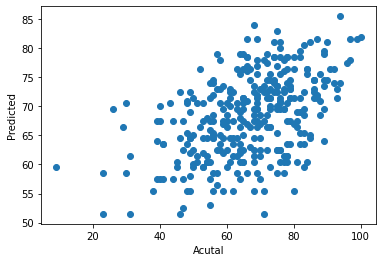

In [33]:
plt.scatter(y_test,y_pred)
plt.xlabel("Acutal")
plt.ylabel("Predicted")

<AxesSubplot: xlabel='avg_score'>

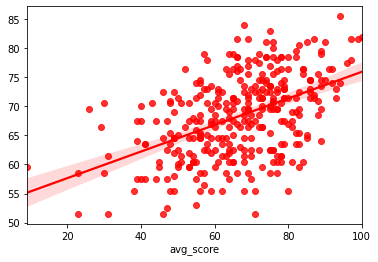

In [34]:
sns.regplot(x=y_test,y=y_pred,color="red")

In [35]:
pd.DataFrame({"Actual":y_test,"Predicted":y_pred,"Difference":y_test-y_pred})

Actual  Predicted  Difference
521    87.0       71.5        15.5
737    64.0       68.0        -4.0
740    75.0       72.5         2.5
660    75.0       58.5        16.5
411    82.0       79.5         2.5
..      ...        ...         ...
506    68.0       61.5         6.5
342    73.0       71.5         1.5
485    72.0       62.5         9.5
711    83.0       80.5         2.5
133    80.0       78.5         1.5

[330 rows x 3 columns]

In [36]:
for i in list(models.values()):
    print(i)

LinearRegression()
Lasso()
Ridge()
KNeighborsRegressor()
DecisionTreeRegressor()
RandomForestRegressor()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [37]:
models

{'Linear Regression': LinearRegression(),
 'Lasso': Lasso(),
 'Ridge': Ridge(),
 'K Neighbour': KNeighborsRegressor(),
 'Decision Tree': DecisionTreeRegressor(),
 'Random Forest': RandomForestRegressor(),
 'XgBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'CatBoost': <catboost.core.Cat

In [38]:
models_params={"regression_params":{},
    "lasso_params" : {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]},
"ridge_params" :{'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]},
"K_neighbours_params":{"n_neighbors":[2,5,8,10],
                     "weights":["uniform", "distance"],
                    "algorithm":["auto","kd_tree","ball_tree"]},
"Decision_regressor_params":{
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "splitter":["best","random"],
    "max_depth":[2,4,7],
    "min_samples_split":[2,4,6,8,10]},
"RandomForestRegressor_params":{
    "n_estimators":[25, 50, 100, 150],
    "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "max_depth":[2,4,7],
    "min_samples_split":[2,4,6,8,10]
},
"XGBRegressor_params":{
    "max_depth":[3,5,9,7,10],
    "gamma":[0.1,0.2,0.3],
    "colsample_bytree":[0.5,0.6,0.7,0.8,0.9]
}}

In [39]:
print(models_params.values())

dict_values([{}, {'alpha': [0.02, 0.024, 0.025, 0.026, 0.03]}, {'alpha': [200, 230, 250, 265, 270, 275, 290, 300, 500]}, {'n_neighbors': [2, 5, 8, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'kd_tree', 'ball_tree']}, {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'splitter': ['best', 'random'], 'max_depth': [2, 4, 7], 'min_samples_split': [2, 4, 6, 8, 10]}, {'n_estimators': [25, 50, 100, 150], 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth': [2, 4, 7], 'min_samples_split': [2, 4, 6, 8, 10]}, {'max_depth': [3, 5, 9, 7, 10], 'gamma': [0.1, 0.2, 0.3], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]}])


In [40]:
def HpyerParameterTuning(model,param,n_jobs,cv,scoring):
    hpt_model=GridSearchCV(model,param,n_jobs=n_jobs,cv=cv)
    hpt_model.fit(x_train,y_train)
    return hpt_model

In [41]:
h_model=[]
for i,j in zip(model_list,models_params.values()):
    n_jobs=5
    cv=3
    scoring="accuracy"
    model=HpyerParameterTuning(i,j,n_jobs,cv,scoring)
    print(model)
    h_model.append(model)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=5, param_grid={})
GridSearchCV(cv=3, estimator=Lasso(), n_jobs=5,
             param_grid={'alpha': [0.02, 0.024, 0.025, 0.026, 0.03]})
GridSearchCV(cv=3, estimator=Ridge(), n_jobs=5,
             param_grid={'alpha': [200, 230, 250, 265, 270, 275, 290, 300,
                                   500]})
GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=5,
             param_grid={'algorithm': ['auto', 'kd_tree', 'ball_tree'],
                         'n_neighbors': [2, 5, 8, 10],
                         'weights': ['uniform', 'distance']})
GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=5,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 4, 7],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'splitter': ['best', 'random']})
GridSearchCV(cv=

In [42]:
h_model

[GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=5, param_grid={}),
 GridSearchCV(cv=3, estimator=Lasso(), n_jobs=5,
              param_grid={'alpha': [0.02, 0.024, 0.025, 0.026, 0.03]}),
 GridSearchCV(cv=3, estimator=Ridge(), n_jobs=5,
              param_grid={'alpha': [200, 230, 250, 265, 270, 275, 290, 300,
                                    500]}),
 GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=5,
              param_grid={'algorithm': ['auto', 'kd_tree', 'ball_tree'],
                          'n_neighbors': [2, 5, 8, 10],
                          'weights': ['uniform', 'distance']}),
 GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=5,
              param_grid={'criterion': ['squared_error', 'friedman_mse',
                                        'absolute_error', 'poisson'],
                          'max_depth': [2, 4, 7],
                          'min_samples_split': [2, 4, 6, 8, 10],
                          'splitter': ['best', 'random'

In [43]:
for i in h_model:
    print(f"Model : {i.best_estimator_}")
    print(f" The Best Parameter for the model {i.best_params_}")
    print(f" Best Score for the Model after the Hyperparamtertuning is {i.best_score_}")
    print(">>"*30)
    print(">>"*30)

Model : LinearRegression()
 The Best Parameter for the model {}
 Best Score for the Model after the Hyperparamtertuning is 0.1642927919951019
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model : Lasso(alpha=0.03)
 The Best Parameter for the model {'alpha': 0.03}
 Best Score for the Model after the Hyperparamtertuning is 0.183558696337221
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model : Ridge(alpha=200)
 The Best Parameter for the model {'alpha': 200}
 Best Score for the Model after the Hyperparamtertuning is 0.14029131332404207
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model : KNeighborsRegressor(n_neighbors=10)
 The Best Parameter for the model {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
 Best Score for the Model after the Hyperpara

In [44]:
m=[]
s=[]
for i in h_model:
    m.append(i.best_estimator_)
    s.append(i.best_score_)
    

In [45]:
d=pd.DataFrame({"Models":m,"Score":s}).sort_values("Score",ascending=False)

In [46]:
d

Models     Score
1                                  Lasso(alpha=0.03)  0.183559
5  (DecisionTreeRegressor(criterion='absolute_err...  0.169095
0                                 LinearRegression()  0.164293
4                 DecisionTreeRegressor(max_depth=2)  0.141016
2                                   Ridge(alpha=200)  0.140291
3                KNeighborsRegressor(n_neighbors=10)  0.106796
6  XGBRegressor(base_score=None, booster=None, ca...  0.035202

In [47]:
y_pred=h_model[1].predict(x_test)

In [48]:
pd.DataFrame({"Actuals":y_test,"Predicted":y_pred,"Difference":y_pred-y_test})

Actuals  Predicted  Difference
521     87.0  70.402866  -16.597134
737     64.0  67.710318    3.710318
740     75.0  72.232244   -2.767756
660     75.0  58.064225  -16.935775
411     82.0  78.785976   -3.214024
..       ...        ...         ...
506     68.0  61.518732   -6.481268
342     73.0  71.737859   -1.262141
485     72.0  62.091766   -9.908234
711     83.0  79.331790   -3.668210
133     80.0  77.849292   -2.150708

[330 rows x 3 columns]

Text(0, 0.5, 'Predicted')

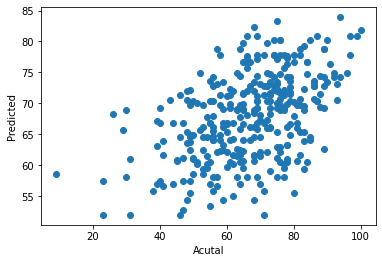

In [49]:
plt.scatter(y_test,y_pred)
plt.xlabel("Acutal")
plt.ylabel("Predicted")

In [50]:
best_model=h_model[1]
best_model

GridSearchCV(cv=3, estimator=Lasso(), n_jobs=5,
             param_grid={'alpha': [0.02, 0.024, 0.025, 0.026, 0.03]})

In [51]:
import pickle

In [52]:
pickle.dump(best_model,open("Model1.pkl","wb"))

In [53]:
model=pickle.load(open("Model1.pkl","rb"))

In [54]:
model.score(x_train,y_train)

0.23543091856747334

In [55]:
model.predict([[1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0]])

array([72.0921793])